Epoch 0: MSE=32.6927, Fisher=0.0245
Epoch 100: MSE=8.9507, Fisher=1.0950
Epoch 200: MSE=1.7454, Fisher=2.5709
Epoch 300: MSE=0.4157, Fisher=3.4682
Epoch 400: MSE=0.2618, Fisher=3.7983


Epoch 0: MSE=32.6927, Fisher=0.0245
Epoch 100: MSE=8.9507, Fisher=1.0950
Epoch 200: MSE=1.7454, Fisher=2.5709
Epoch 300: MSE=0.4157, Fisher=3.4682
Epoch 400: MSE=0.2618, Fisher=3.7983


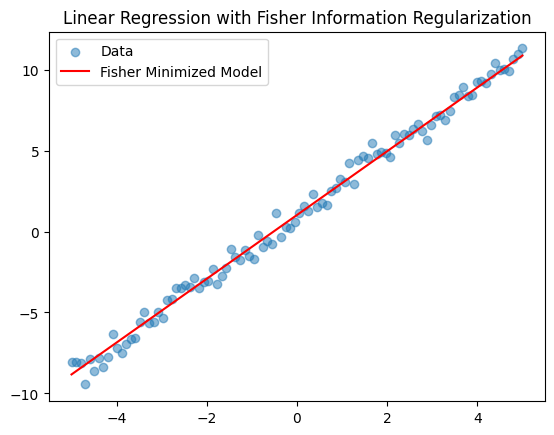

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

torch.manual_seed(42)
x = torch.linspace(-5, 5, 100).view(-1, 1)
y = 2 * x + 1 + torch.randn(x.size()) * 0.5

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

model = SimpleNet()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 500
fisher_penalty_weight = 0.1  # Hyperparameter to control smoothness

for epoch in range(epochs):
    optimizer.zero_grad()

    predictions = model(x)
    mse_loss = nn.MSELoss()(predictions, y)

    x_input = x.clone().detach().requires_grad_(True)
    out = model(x_input)

    grad_outputs = torch.ones_like(out)
    grad_x = torch.autograd.grad(outputs=out, inputs=x_input,
                                 grad_outputs=grad_outputs,
                                 create_graph=True)[0]

    fisher_loss = torch.mean(grad_x**2)

    total_loss = mse_loss + (fisher_penalty_weight * fisher_loss)

    total_loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: MSE={mse_loss.item():.4f}, Fisher={fisher_loss.item():.4f}")

model.eval()
with torch.no_grad():
    final_pred = model(x).numpy()

plt.scatter(x.numpy(), y.numpy(), label='Data', alpha=0.5)
plt.plot(x.numpy(), final_pred, color='red', label='Fisher Minimized Model')
plt.legend()
plt.title("Linear Regression with Fisher Information Regularization")
plt.show()

Using device: cuda
Starting Training...
Epoch 0 | Loss: 0.73808
Epoch 200 | Loss: 0.01679
Epoch 400 | Loss: 0.00783
Epoch 600 | Loss: 0.00548
Epoch 800 | Loss: 0.00182
Epoch 1000 | Loss: 0.00102
Epoch 1200 | Loss: 0.00071
Epoch 1400 | Loss: 0.00093
Epoch 1600 | Loss: 0.00051
Epoch 1800 | Loss: 0.00025
Final New Model Loss: 0.00026
Training Complete. Plotting...
Image saved as 'add3conv.png'


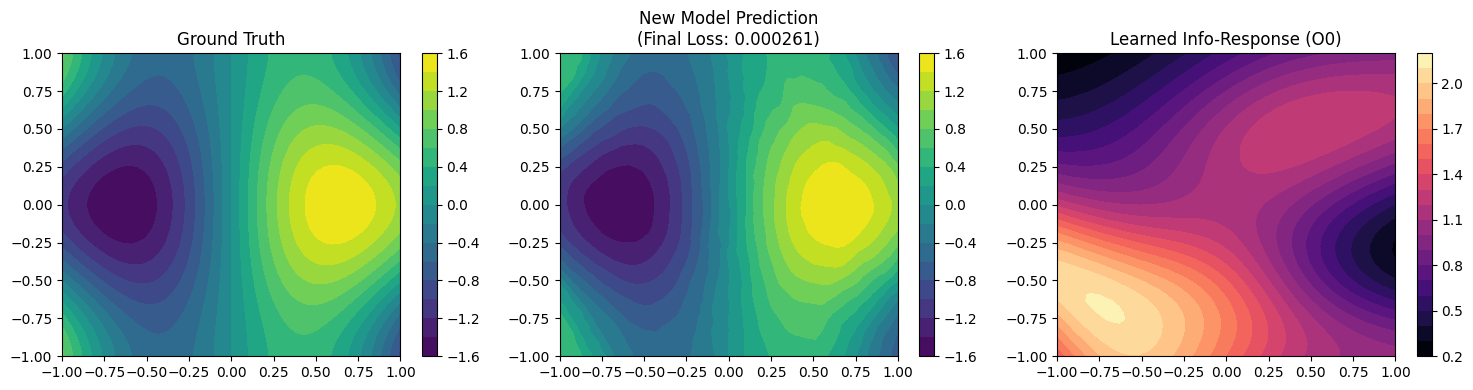

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

D_IN = 2    # Input dimension (d)
D_OUT = 1   # Output dimension

K_PROBES = 4          # Number of probe directions (K) [cite: 10]
HIDDEN_DIM = 32       # Dimension for Energy/Embedding net
EPSILON = 0.1         # Perturbation size (theta) [cite: 16]
LAMBDA_JET = 0.1      # Weight for alignment in Jet Loss
ETA_JET = 0.5         # Weight of Jet Loss in total loss [cite: 82]

LR = 0.005
EPOCHS = 2000
BATCH_SIZE = 64

# Device setup for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class InfoResponseModel(nn.Module):
    def __init__(self, d_in, hidden_dim, k_probes, epsilon):
        super().__init__()
        self.d_in = d_in
        self.epsilon = epsilon
        self.k_probes = k_probes

        v = torch.randn(k_probes, d_in)
        v = v / torch.norm(v, dim=1, keepdim=True) # Normalize
        self.register_buffer('probes', v)

        self.energy_net = nn.Sequential(
            nn.Linear(d_in, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1) # Output is scalar Energy
        )

        # Convolutional layers between energy_net and pred_net
        self.conv_layer = nn.Sequential(
                nn.Conv1d(1, 8, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(8, 16, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv1d(16, 32, kernel_size=3, padding=1)
        )
        
        self.pred_net = nn.Sequential(
            nn.Linear(32 * hidden_dim + 5, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def get_energy_and_embedding(self, x):
        h = x
        for i, layer in enumerate(self.energy_net):
            h = layer(h)
            if i == len(self.energy_net) - 2:
                embedding = h
        energy = h
        return energy, embedding

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        energy, _ = self.get_energy_and_embedding(x)

        grads = torch.autograd.grad(
            outputs=energy.sum(),
            inputs=x,
            create_graph=True, # Important for higher-order derivatives
            retain_graph=True
        )[0] # Shape: (Batch, d_in)

        scores = -torch.matmul(grads, self.probes.T)
        return scores

    def compute_local_fisher(self, x):
        """Computes I_psi(theta; x) at theta=0 (approx) via scores."""
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def compute_fisher_on_output(self, layer_output, x):
        """Compute Fisher information on a layer output with respect to input x."""
        if not x.requires_grad:
            x.requires_grad_(True)
        
        # Compute gradient of layer output mean with respect to input
        grads = torch.autograd.grad(
            outputs=layer_output.sum(),
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]
        
        # Compute score using probes
        if grads.dim() > 1:
            grads_flat = grads.view(grads.size(0), -1)
        else:
            grads_flat = grads
        
        scores = -torch.matmul(grads_flat, self.probes.T)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        training_mode = self.training

        with torch.set_grad_enabled(True):
            if not x.requires_grad:
                x.requires_grad_(True)

            O0 = self.compute_local_fisher(x)

            I_pos_list = []
            I_neg_list = []

            for k in range(self.k_probes):
                v_k = self.probes[k].unsqueeze(0) # (1, d)

                x_pos = x + self.epsilon * v_k
                s_pos = self.compute_score(x_pos) # Score at perturbed point
                pass

            mean_v = self.probes.mean(dim=0, keepdim=True)
            x_pos = x + self.epsilon * mean_v
            x_neg = x - self.epsilon * mean_v

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        _, h = self.get_energy_and_embedding(x)

        # Compute Fisher information between energy_net and conv_layer
        with torch.set_grad_enabled(True):
            fish_energy_net = self.compute_fisher_on_output(h, x)

        # Apply convolutional layers between energy_net and pred_net
        # Reshape h from [batch, hidden_dim] to [batch, 1, hidden_dim]
        h_conv = h.unsqueeze(1)
        h_conv = self.conv_layer(h_conv)  # Output: [batch, 32, hidden_dim]
        
        # Compute Fisher information between conv_layer and pred_net
        with torch.set_grad_enabled(True):
            fish_conv_layer = self.compute_fisher_on_output(h_conv, x)
        
        h_conv = h_conv.view(h_conv.size(0), -1)  # Flatten: [batch, 32*hidden_dim]
        
        features = torch.cat([h_conv, O0, O1, O2, fish_energy_net, fish_conv_layer], dim=1)
        y_hat = self.pred_net(features)

        return y_hat, O0 # Return O0 for viz/loss if needed

def target_function(x):
    return torch.sin(3 * x[:, 0]) + torch.cos(3 * x[:, 1]) * x[:, 0]

X = torch.rand(500, D_IN) * 2 - 1  # Range [-1, 1]
X = X.to(device)
Y = target_function(X).unsqueeze(1)
Y = Y.to(device)

model = InfoResponseModel(D_IN, HIDDEN_DIM, K_PROBES, EPSILON)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
criterion = criterion.to(device)

loss_history = []

print("Starting Training...")
for epoch in range(EPOCHS):
    optimizer.zero_grad()

    preds, energy_score = model(X)
    loss_sup = criterion(preds, Y)
    mean_v = model.probes.mean(dim=0, keepdim=True)
    loss = loss_sup

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

final_loss = loss.item()
print(f"Final New Model Loss: {final_loss:.5f}")

print("Training Complete. Plotting...")

n_grid = 50
x_space = np.linspace(-1, 1, n_grid)
y_space = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x_space, y_space)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
grid_tensor = grid_tensor.to(device)

preds, info_field = model(grid_tensor)
ground_truth = target_function(grid_tensor)

preds = preds.detach().cpu().reshape(n_grid, n_grid).numpy()
gt = ground_truth.detach().cpu().reshape(n_grid, n_grid).numpy()
info = info_field.detach().cpu().reshape(n_grid, n_grid).numpy()

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].set_title("Ground Truth")
im0 = axs[0].contourf(xx, yy, gt, levels=20)
plt.colorbar(im0, ax=axs[0])

axs[1].set_title(f"New Model Prediction\n(Final Loss: {final_loss:.6f})")
im1 = axs[1].contourf(xx, yy, preds, levels=20)
plt.colorbar(im1, ax=axs[1])

axs[2].set_title("Learned Info-Response (O0)")
# O0 represents the local sensitivity/Fisher info [cite: 45]
im2 = axs[2].contourf(xx, yy, info, levels=20, cmap='magma')
plt.colorbar(im2, ax=axs[2])

plt.tight_layout()
plt.savefig('add3conv.png', dpi=150, bbox_inches='tight')
print("Image saved as 'add3conv.png'")
plt.show()


Starting MLP Training...
Epoch 0 | Loss: 0.73364
Epoch 200 | Loss: 0.00059
Epoch 400 | Loss: 0.00023
Epoch 600 | Loss: 0.00109
Epoch 800 | Loss: 0.00010
Epoch 1000 | Loss: 0.00066
Epoch 1200 | Loss: 0.00005
Epoch 1400 | Loss: 0.00026
Epoch 1600 | Loss: 0.00014
Epoch 1800 | Loss: 0.00003
Final MLP Loss: 0.00065


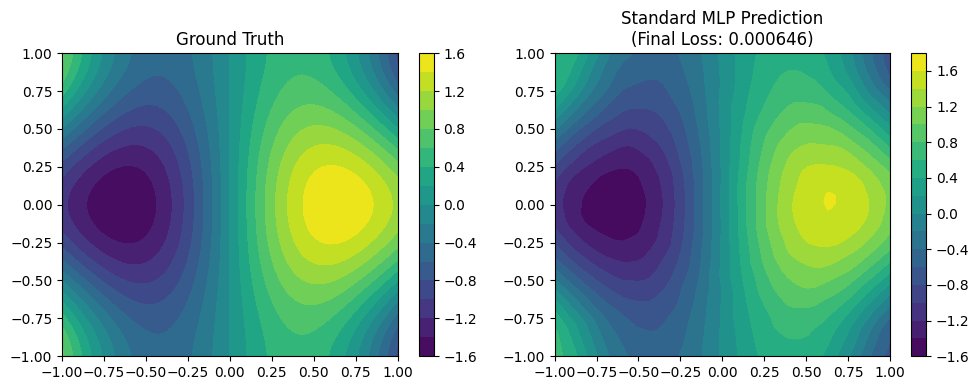

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Configuration
# ==========================================
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

D_IN = 2
HIDDEN_DIM = 64  # Increased slightly to give the MLP a fair chance
LR = 0.01        # Standard learning rate
EPOCHS = 2000

# ==========================================
# 2. Standard MLP Model
# ==========================================
class StandardMLP(nn.Module):
    def __init__(self, d_in, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), # Extra layer for depth
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

# ==========================================
# 3. Data Generation (Same as before)
# ==========================================
def target_function(x):
    # sin(x1) + cos(x2) * x1
    return torch.sin(3 * x[:, 0]) + torch.cos(3 * x[:, 1]) * x[:, 0]

X = torch.rand(500, D_IN) * 2 - 1  # Range [-1, 1]
Y = target_function(X).unsqueeze(1)

# ==========================================
# 4. Training Loop
# ==========================================
model_mlp = StandardMLP(D_IN, HIDDEN_DIM)
optimizer = optim.Adam(model_mlp.parameters(), lr=LR)
criterion = nn.MSELoss()

loss_history_mlp = []

print("Starting MLP Training...")
for epoch in range(EPOCHS):
    optimizer.zero_grad()

    preds = model_mlp(X)
    loss = criterion(preds, Y)

    loss.backward()
    optimizer.step()

    loss_history_mlp.append(loss.item())

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

final_loss = loss.item()
print(f"Final MLP Loss: {final_loss:.5f}")

# ==========================================
# 5. Visualization
# ==========================================
n_grid = 50
x_space = np.linspace(-1, 1, n_grid)
y_space = np.linspace(-1, 1, n_grid)
xx, yy = np.meshgrid(x_space, y_space)
grid_tensor = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)

with torch.no_grad():
    preds_mlp = model_mlp(grid_tensor)
    ground_truth = target_function(grid_tensor)

preds_mlp = preds_mlp.reshape(n_grid, n_grid).numpy()
gt = ground_truth.reshape(n_grid, n_grid).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_title("Ground Truth")
im0 = axs[0].contourf(xx, yy, gt, levels=20)
plt.colorbar(im0, ax=axs[0])

axs[1].set_title(f"Standard MLP Prediction\n(Final Loss: {final_loss:.6f})")
im1 = axs[1].contourf(xx, yy, preds_mlp, levels=20)
plt.colorbar(im1, ax=axs[1])

plt.tight_layout()
plt.show()

In [10]:

import torch, torchvision

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

print(model)

intro = nn.Sequential(
    model.conv1,
    model.bn1,
    model.relu,
    model.maxpool
)
layer1 = model.layer1
layer2 = model.layer2
layer3 = model.layer3
layer4 = model.layer4
averagepool = model.avgpool
fc = model.fc



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using device: cuda
Train samples: 60000, Test samples: 10000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Starting MNIST Training...
Epoch 0, Batch 0/938: Loss=2.2959
Epoch 0, Batch 100/938: Loss=0.3208
Epoch 0, Batch 200/938: Loss=0.3518
Epoch 0, Batch 300/938: Loss=0.0442
Epoch 0, Batch 400/938: Loss=0.2399
Epoch 0, Batch 500/938: Loss=0.0096
Epoch 0, Batch 600/938: Loss=0.0691
Epoch 0, Batch 700/938: Loss=0.1200
Epoch 0, Batch 800/938: Loss=0.0208
Epoch 0, Batch 900/938: Loss=0.1392
Epoch 0 | Train Loss: 0.1763 | Test Accuracy: 97.96%
Epoch 1, Batch 0/938: Loss=0.0187
Epoch 1, Batch 100/938: Loss=0.0852
Epoch 1, Batch 200/938: Loss=0.0843
Epoch 1, Batch 300/938: Loss=0.0198
Epoch 1, Batch 400/938: Loss=0.0031
Epoch 1, Batch 500/938: Loss=0.1406
Epoch 1, Batch 600/938: Loss=0.0238
Epoch 1, Batch 700/938: Loss=0.0287
Epoch 1, Batch 800/938: Loss=0.0263
Epoch 1, Batch 900/938: Loss=0.0189
Epoch 1 | Train Loss: 0.0670 | Test Accuracy: 98.92%
Final Test Accuracy: 98.92%
Training plots saved as 'mnist_training.png'


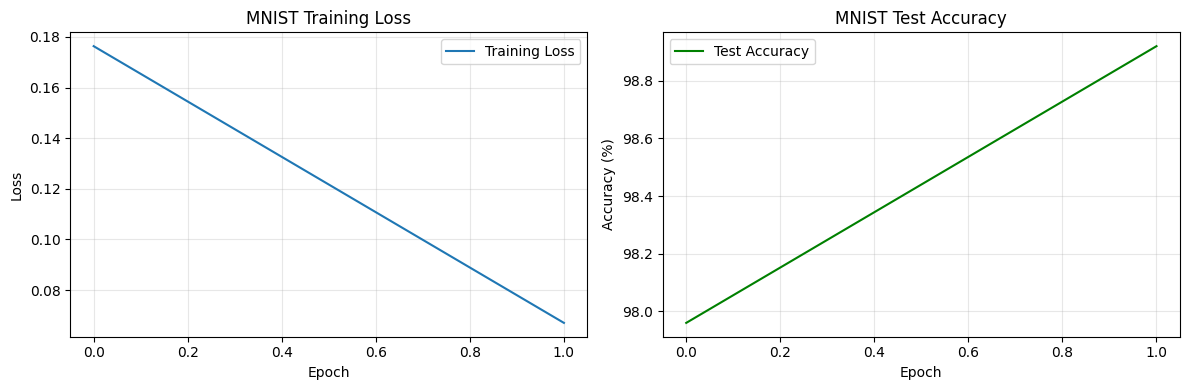

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Dataset parameters
NUM_CLASSES = 10
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001

K_PROBES = 4
EPSILON = 0.1

# Device setup for CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

class MNISTClassifier(nn.Module):
    def __init__(self, num_classes, k_probes, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.k_probes = k_probes
        self.num_classes = num_classes

        v = torch.randn(k_probes, 2)  # 2D probe directions
        v = v / torch.norm(v, dim=1, keepdim=True)
        self.register_buffer('probes', v)

        # ResNet18 backbone
        resnet_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        self.intro = nn.Sequential(
            resnet_model.conv1,
            resnet_model.bn1,
            resnet_model.relu,
            resnet_model.maxpool
        )
        self.layer1 = resnet_model.layer1
        self.layer2 = resnet_model.layer2
        self.layer3 = resnet_model.layer3
        self.layer4 = resnet_model.layer4
        self.averagepool = resnet_model.avgpool

        # Convolutional layers for feature processing
        self.conv_layer = nn.Sequential(
            nn.Conv1d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(16, 32, kernel_size=3, padding=1)
        )

        # Classification head (Fixed: 512 + 3 (O0, O1, O2) + 4 (fish layers) = 519)
        self.classifier = nn.Sequential(
            nn.Linear(512 + 3 + 4, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def compute_score(self, x):
        if not x.requires_grad:
            x.requires_grad_(True)

        # Compute energy as mean of representation
        energy = x.mean()

        grads = torch.autograd.grad(
            outputs=energy,
            inputs=x,
            create_graph=True,
            retain_graph=True
        )[0]

        grads_flat = grads.view(grads.size(0), -1)

        # Use only first 2 dimensions or project to 2D space
        if grads_flat.size(1) >= 2:
            grads_2d = grads_flat[:, :2]
        else:
            grads_2d = grads_flat

        scores = -torch.matmul(grads_2d, self.probes.T)
        return scores

    def compute_local_fisher(self, x):
        scores = self.compute_score(x)
        fisher_info = (scores ** 2).mean(dim=1, keepdim=True)
        return fisher_info

    def forward(self, x):
        # x shape: [batch, 1, 28, 28]
        batch_size = x.size(0)

        # Convert 1-channel to 3-channel (RGB) by repeating
        if x.size(1) == 1:
            x = x.repeat(1, 3, 1, 1)  # [batch, 3, 28, 28]

        # Resize to ResNet input size (224x224)
        x_resized = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        with torch.set_grad_enabled(True):
            if not x_resized.requires_grad:
                x_resized.requires_grad_(True)

            # Compute derivatives with respect to input
            O0 = self.compute_local_fisher(x_resized)

            # For image tensors, use small Gaussian perturbations instead of probe directions
            perturbation = torch.randn_like(x_resized) * self.epsilon
            x_pos = x_resized + perturbation
            x_neg = x_resized - perturbation

            I_pos = self.compute_local_fisher(x_pos)
            I_neg = self.compute_local_fisher(x_neg)

            O1 = (I_pos - I_neg) / (2 * self.epsilon)
            O2 = (I_pos - 2 * O0 + I_neg) / (self.epsilon ** 2)

        # Forward through ResNet
        h = self.intro(x_resized)

        # Apply layers and compute Fisher at each stage
        h = self.layer1(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fish_layer1 = self.compute_local_fisher(h)

        h = self.layer2(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fish_layer2 = self.compute_local_fisher(h)

        h = self.layer3(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fish_layer3 = self.compute_local_fisher(h)

        h = self.layer4(h)
        with torch.set_grad_enabled(True):
            if not h.requires_grad:
                h.requires_grad_(True)
            fish_layer4 = self.compute_local_fisher(h)

        # Global average pool
        h_pooled = self.averagepool(h)
        h_flat = h_pooled.view(batch_size, -1)  # [batch, 512]

        # Concatenate all features (skip conv_layer processing for now)
        fish_concat = torch.cat([fish_layer1, fish_layer2, fish_layer3, fish_layer4], dim=1)
        features = torch.cat([h_flat, O0, O1, O2, fish_concat], dim=1)

        # Classify
        logits = self.classifier(features)
        return logits

# Create model
model = MNISTClassifier(NUM_CLASSES, K_PROBES, EPSILON)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_losses = []
test_accuracies = []

print("Starting MNIST Training...")
# for epoch in range(EPOCHS):
for epoch in range(2):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate on test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

# Plot training results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('MNIST Training Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(test_accuracies, label='Test Accuracy', color='green')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('MNIST Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('mnist_training.png', dpi=150, bbox_inches='tight')
print("Training plots saved as 'mnist_training.png'")
plt.show()


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LR = 0.001

# Download and prepare MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # MNIST mean and std
])

print("Downloading MNIST dataset...")
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

# Download ResNet18 (not pretrained)
print("Downloading ResNet18 model...")
resnet18 = models.resnet18(pretrained=False)

# Modify first layer to accept 1-channel input (MNIST is grayscale)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify output layer for 10 classes
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 10)

model = resnet18.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

print("Starting Training for 2 epochs...")
train_losses = []
test_accuracies = []

for epoch in range(EPOCHS):
    # Training phase
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
        
        if batch_idx % 150 == 0:
            print(f"Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}: Loss={loss.item():.4f}")
    
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    # Evaluation phase
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    
    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")

print("\nTraining Complete!")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")


Using device: cuda
Train samples: 60000, Test samples: 10000


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Starting Training for 2 epochs...
Epoch 0, Batch 0/938: Loss=2.4871
Epoch 0, Batch 150/938: Loss=0.1558
Epoch 0, Batch 300/938: Loss=0.0663
Epoch 0, Batch 450/938: Loss=0.1388
Epoch 0, Batch 600/938: Loss=0.0798
Epoch 0, Batch 750/938: Loss=0.1385
Epoch 0, Batch 900/938: Loss=0.0766
Epoch 0 | Train Loss: 0.1335 | Test Accuracy: 97.89%
Epoch 1, Batch 0/938: Loss=0.0847
Epoch 1, Batch 150/938: Loss=0.1110
Epoch 1, Batch 300/938: Loss=0.0657
Epoch 1, Batch 450/938: Loss=0.1136
Epoch 1, Batch 600/938: Loss=0.0583
Epoch 1, Batch 750/938: Loss=0.0278
Epoch 1, Batch 900/938: Loss=0.1695
Epoch 1 | Train Loss: 0.0624 | Test Accuracy: 97.73%

Training Complete!
Final Test Accuracy: 97.73%
